In [6]:
import numpy as np
import pandas as pd
import pickle
import librosa
import matplotlib.pyplot as plt
import re
import seaborn as sns
import random

with open(r"dataset.pkl", 'rb') as data:
    midi_data = pickle.load(data)

notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

In [7]:
# define helper functions

'''Takes in name of sample (str) and outputs the labeled progression of either length 32 or length 64
    Parameters:
        midi_seq: string of input name
    Output:
        list with elements being the roots of the chord labels        
'''
# get an array equal to the length of the note matrix where each element is the root note at time n 
def get_progression(midi_seq):
    seq = midi_data[midi_seq]
    roots = np.array(seq['root'])
    roots = roots.flatten()
    roots = [notes[root] for root in roots]
    return roots


'''Takes in name of sample (str) and outputs the key of the progression
    Parameters:
        midi_seq: string of input name
    Output:
        string with the key of the progression (including either min or major)    
'''
# use tonic and mode info to get key of the progression
def get_key(midi_seq):
    seq = midi_data[midi_seq]
    tonic = seq['tonic']
    mode = seq['mode']
    note_name = notes[tonic]
    if mode == 'm':
        note_name += 'm'
    return note_name


'''Takes in name of sample (str)
    Parameters:
        midi_seq: string of input name
    Output:
        dictionary with # eigth note as key and 
        a dictionary as the values that has notes as key and amplitude as value
'''
def get_note_map(midi_seq):
    seq = midi_data[midi_seq]
    #get note matrix
    nmat = seq['nmat']
    # get duration from length of progression
    progression = get_progression(midi_seq)
    len_sequence = len(progression)
    beats = range(len_sequence + 1)
    # create empty map with the # of beats as the key
    note_map = {key:{note:0 for note in notes} for key in beats}
    for row in nmat:
        start = row[0]
        end = row[1]
        note = librosa.midi_to_note(row[2], unicode=False, octave=False)
        amplitude = row[3]
        for beat in range(start, end + 1):
            note_at_beat = note_map[beat][note]
            # add the amplitude to the current value of the note in the note map
            note_map[beat][note] = note_at_beat + amplitude
    return note_map

Time(s),C,C#,D,D#,E,F,F#,G,G#,A,A#,B,Chord Actual
0.00,0,117,0,0,73,0,0,0,0,74,0,0,A
0.25,0,117,0,0,73,0,0,0,0,74,0,0,A
0.50,0,117,0,0,73,0,0,0,0,74,0,0,A
0.75,0,108,0,0,73,0,0,0,0,74,0,0,A
1.00,0,224,0,0,73,0,0,0,0,74,0,0,A
1.25,0,116,0,0,73,0,0,0,0,74,0,116,A
1.50,0,0,0,0,0,0,0,0,0,86,0,116,A
1.75,0,0,0,0,0,0,0,102,0,86,0,0,A
2.00,0,0,0,0,0,0,196,102,0,0,0,168,B
2.25,0,0,0,0,0,0,196,0,0,0,0,168,B


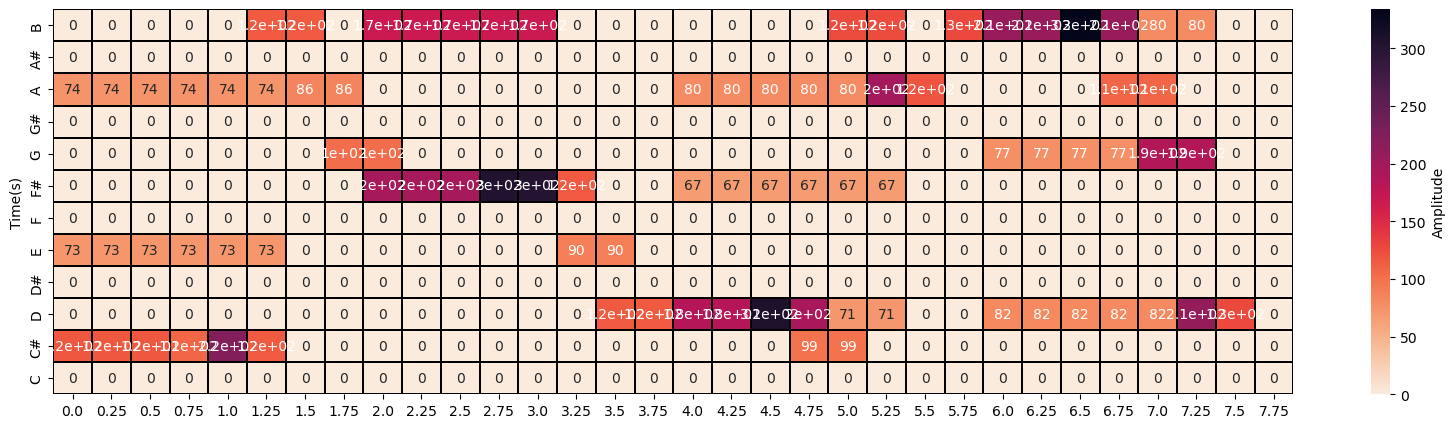

In [23]:
# takes in key name of point in dataset and outputs the chroma matrix and chromagram visualization
'''
Takes in name of sample (str) and outputs chromagram plot and dataframe

Parameters:
    midi_seq: name of sample 
Output:
    chromagram plot: heatmap with times as columns, note bins as rows, and values within each box is the amplitude of the note at that time
    
    chromagram dataframe: dataframe with time as the index, note bins as columns with values being their amplitude, and a column at the end that 
    contains the labeled root of the chord at that time 

'''
def get_chromagram(midi_seq):
    # get map of times and note amplitudes at each time
    note_data = get_note_map(midi_seq)
    # get progression from roots
    progression = get_progression(midi_seq)
    duration = len(progression)
    # get times from eigth notes -> each note is 0.25 seconds
    times = np.arange(start=0, stop=(duration * 0.25), step=0.25)
    # get the amplitude values of each note bin for all times 
    map = [list(note_data[time].values()) for time in range(duration)] 
    # flip rows and cols -> pitch class as rows and times as cols 
    chroma_map = pd.DataFrame(map).transpose()
    # set notes as rows and times as columns for plotting 
    chroma_map.index = notes
    chroma_map.index.name = 'Time(s)'
    chroma_map.columns = times
    # get heatmap from df
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.heatmap(chroma_map, cmap= 'rocket_r', annot=True, linewidth=0.03, linecolor='black', cbar_kws={'label': 'Amplitude'})
    # make notes from C-Bb instead of Bb-C on plot
    plt.gca().invert_yaxis()
    # flip df back to having times as rows and chords as columns
    chroma_map = chroma_map.transpose()
    # add labeled chord as a column to dataframe
    chroma_map.insert(12, 'Chord Actual', value=progression)
    return chroma_map

get_chromagram('Niko_Kotoulas_Melody_9_A-Bm-D-G (V-vi-I-IV) - 115-130bpm.mid')

In [26]:
'''
Function to rotate the list of notes so that the first element becomes the root and the following elements are the consecutive chords rotated for that scale

Parameters: 
    original notes C through B (list)
    tonic from midi sequence data (int)

Output:
    rotated list of note strings
'''

# change the indices of the notes so that the key will be the first chord 
def rotate_list(notes, tonic):
    try:
        # get root note of first chord in prog
        key_root = notes[tonic]
        # get the curr index of the root note in notes list 
        index = notes.index(key_root)
    except ValueError:
        print(f"{key_root} not found in the list.")
        return notes
    # use splicing and concatonation to rotate the notes list so that there are still 12 elements but the first element and preceding elements are flipped for the given key 
    rotated_lst = notes[index:] + notes[:index]
    return rotated_lst

rotate_list(notes, 7)

['G', 'G#', 'A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#']

In [32]:
'''
Function that takes in string of sample name with a major mode
and outputs a list of the chords in that key 

Parameters:
    midi sample name (str)
    
Output:
    chords in the key of the provided sequence name
'''
def get_maj_scale(notes, midi_seq):
    seq = midi_data[midi_seq]
    key_chords = []
    # get key info
    tonic = seq['tonic']
    notes_rotated = rotate_list(notes, tonic)
    '''
    1) tonic, root (major)
    2) 2 semitones up (minor)
    3) 2 semitones up (minor)
    4) 1 semitone up (major)
    5) 2 semitones up (major)
    6) 2 semitones up (minor)
    7) 2 semitones up (diminished)
    '''
    key_chords.append(notes_rotated[0])
    key_chords.append(notes_rotated[2] + 'm')
    key_chords.append(notes_rotated[4] + 'm')
    key_chords.append(notes_rotated[5])
    key_chords.append(notes_rotated[7])
    key_chords.append(notes_rotated[9] + 'm')
    key_chords.append(notes_rotated[11] + 'dim')
    return key_chords

get_maj_scale(notes, 'Niko_Kotoulas_Melody_4_B-G#m-D#-E (I-vi-iii-IV) - 130-160bpm.mid')

['B', 'C#m', 'D#m', 'E', 'F#', 'G#m', 'A#dim']

In [30]:
'''
Function that takes in string of sample name with a minor mode
and outputs a list of the chords in that key 

Parameters:
    midi sample name (str)
    
Output:
    chords in the key of the provided sequence name
'''
def get_minor_scale(notes, midi_seq):
    seq = midi_data[midi_seq]
    key_chords = []
    # get key info
    tonic = seq['tonic']
    notes_rotated = rotate_list(notes, tonic)
    '''
    1) tonic, root (minor)
    2) 2 semitones up (diminished)
    3) 1 semitone up (major)
    4) 2 semitones up (minor)
    5) 2 semitones up (minor)
    6) 1 semitones up (major)
    7) 2 semitones up (major)
    '''
    key_chords.append(notes_rotated[0] + 'm')
    key_chords.append(notes_rotated[2] + 'dim')
    key_chords.append(notes_rotated[3])
    key_chords.append(notes_rotated[5] + 'm')
    key_chords.append(notes_rotated[7] + 'm')
    key_chords.append(notes_rotated[8])
    key_chords.append(notes_rotated[10])
    return key_chords

get_minor_scale(notes, 'Niko_Kotoulas_ChordProg_7_C#m-G#m-E-F# (ii-vi-IV-V).mid')

['G#m', 'A#dim', 'B', 'C#m', 'D#m', 'E', 'F#']

In [ ]:
# def align_chromagram_labels(midi_seq):
#     # get chroma map without actual chord labs
#     chroma_map = get_chromagram(midi_seq)
#     chroma_notes = chroma_map.iloc[:, :12]
#     seq = midi_data[midi_seq]
#     labels = chroma_map['Chord Actual']
#     # check if sequence is in a minor or major scale
#     if seq['mode'] == 'm':
#         seq_scale = get_minor_scale(notes, midi_seq)
#     else:
#         seq_scale = get_maj_scale(notes, midi_seq)
#     # get current chords from chromagram
#     roots_in_seq = list(set(labels))
#     # join list of chords into a single string to parse for regex and replace in chroma labels
#     scale_to_string = (' ').join(seq_scale)
#     for chord in roots_in_seq:
#         if chord not in seq_scale:
#             # define regex pattern to get an instance of the chord 
#             pattern = fr'\b\w*{chord}\w*\b'
#             true_chord = re.findall(pattern, scale_to_string, flags=re.IGNORECASE)[0]
#             chroma_map = chroma_map.replace()
#     return chroma_map

{'C#', 'E', 'F#', 'G#'}

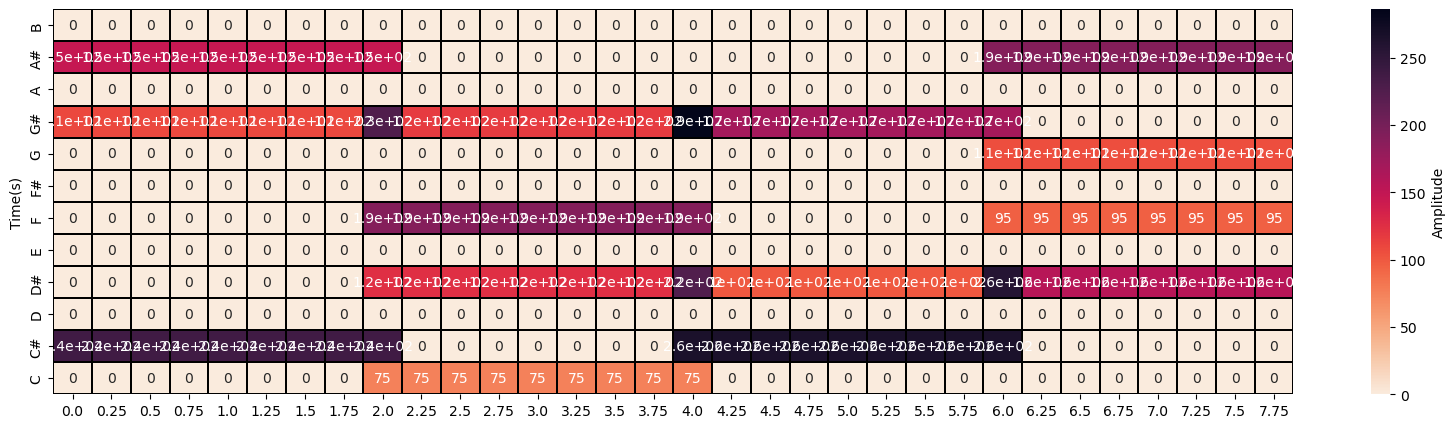

In [54]:
# cmap = get_chromagram('Niko_Kotoulas_ChordProg_7_C#m-G#m-E-F# (ii-vi-IV-V).mid')
# set(cmap['Chord Actual'])
# #align_chromagram_labels('')